## Test Case: Applications to real world EHR data

We have a dataset that includes demographic information,
diagnoses, and Emergency Department (ED) visits for a cohort of
patients over the period 2010-2012. This is a small, relatively simple dataset with only 400 unique patients.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os
import json

# import locally stored library
sys.path.append('C:\\Users\\dreww\\Desktop')
from icd9 import icd9

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

,empi,dia_date,dia_code,dia_name,provider,dia_flag,inpatient_outpatient
0,412857024,2012-04-01,291.2,Alcohol-induced persisting dementia,"Hosseini, Ahmad, M.D.",admitting,inpatient
1,733570627,2011-12-07,260,Kwashiorkor,"Hansen, Michael, M.D.",primary,outpatient
2,838754425,2013-06-23,416,Chronic pulmonary heart disease,"Hansen, Michael, M.D.",admitting,inpatient
3,546413564,2010-12-11,729.1,"Mylagia and myositis, unspecified","Dirichlet, Amir, M.D.",admitting,inpatient
4,452148563,2008-07-29,272.4,Other and unspecified hyperlipidemia,"Armstrong, Sebastian, M.D.",NaN,outpatient


(5893, 7)

Number of unique patients:  400
Avg number of diagnoses per person:  14.7325


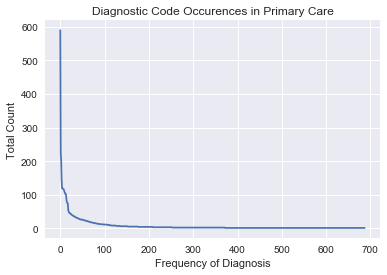

In [2]:
# this dataset contains information on the date and nature of primary diagnoses
diag = pd.read_csv('data/Harvard EHR Dataset/dia.csv')
diag.head()
diag.shape
print('Number of unique patients: ', diag.empi.nunique())
print('Avg number of diagnoses per person: ', diag.groupby('empi').count()['dia_code'].mean())
y = diag.dia_code.value_counts().sort_values(ascending=False).values
x = np.arange(0, len(diag.dia_code.unique()))
_ = plt.plot(x, y)
_ = plt.ylabel('Total Count')
_ = plt.xlabel('Frequency of Diagnosis')
_ = plt.title('Diagnostic Code Occurences in Primary Care')

In [3]:
# this dataset contains demographic information and indication of mortality
dem = pd.read_csv('data/Harvard EHR Dataset/dem.csv')
dem.head()
dem.shape
print('Deceased %: ', dem.date_of_death.isna().sum() / len(dem))
dem.gender.value_counts()
dem.age.describe()
dem.vital_status.value_counts()

,empi,name,gender,date_of_birth,age,race,vital_status,date_of_death
0,742415486,Ms.Baudoin,female,1937-08-07,77,Black-BLACK,NaN,NaN
1,746287608,Ms.Koo,female,1983-04-21,31,White-WHITE,NaN,NaN
2,415900342,Ms.Shurtleff,female,1918-03-11,96,White-WHITE,NaN,NaN
3,967071533,Ms.Mukai,female,1947-04-01,67,Black-BLACK,NaN,NaN
4,679830259,Ms.Haapala,female,1967-02-03,47,Black-BLACK,NaN,NaN


(400, 8)

Deceased %:  0.6625


female    200
male      200
Name: gender, dtype: int64

count    400.00000
mean      69.43500
std       21.77835
min       22.00000
25%       50.00000
50%       73.00000
75%       91.00000
max       97.00000
Name: age, dtype: float64

deceased    135
Name: vital_status, dtype: int64

In [4]:
# this dataset describes emergency department visits, icd9 codes with descriptions, and clinical notes 
ed_notes = pd.read_csv('data/Harvard EHR Dataset/ed_visits.txt', delimiter='$')
ed_notes.head()
print('Average number of ER visits ', np.mean(ed_notes.groupby(['empi'])['visit_date'].count()))
ed_notes.length_of_stay.describe()

,empi,visit_date,admit_date,discharge_date,length_of_stay,principal_dia_code,principal_dia_name,additional_dia_code,note_text
0,940785937,2013-05-14,2013-05-14 23:59:19,2013-05-15 00:52:57,54,724.2,Lumbago,"719.46,786.2,786.2,V62.85",[report_beginning]\n\n940785937|2013-05-14|fin...
1,412857024,2012-01-20,2012-01-20 22:53:54,2012-01-21 02:51:49,238,781.0,Abnormal involuntary movements,NaN,[report_beginning]\n\n412857024|2012-01-20|fin...
2,285331782,2011-12-09,2011-12-09 12:54:56,2011-12-09 17:37:59,283,786.59,Other chest pain,"996.73,719.46,724.2,959.09",[report_beginning]\n\n285331782|2011-12-09|fin...
3,916658044,2011-05-23,2011-05-23 14:12:04,2011-05-23 21:21:44,430,780.4,Dizziness and giddiness,"719.46,820.8,789.01,780.50",[report_beginning]\n\n916658044|2011-05-23|fin...
4,172824291,2012-09-30,2012-09-30 03:44:42,2012-09-30 07:32:36,228,789.02,"Abdominal pain, left upper quadrant","540.9,998.30,784.2,578.9",[report_beginning]\n\n172824291|2012-09-30|uns...


Average number of ER visits  2.4884393063583814


count    869.000000
mean     232.133487
std      118.202272
min     -127.000000
25%      145.000000
50%      232.000000
75%      310.000000
max      650.000000
Name: length_of_stay, dtype: float64

principal_dia_code     308
additional_dia_code    831
dtype: int64

1135

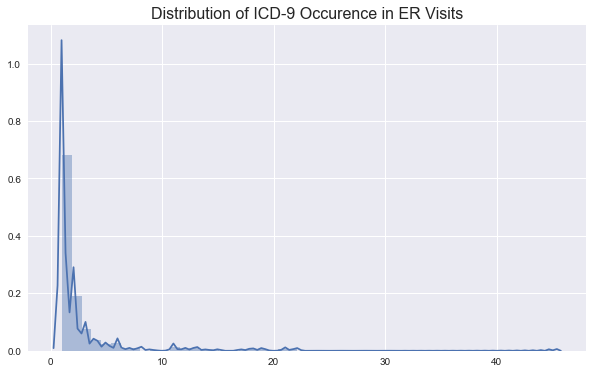

In [5]:
diagnoses = ed_notes.principal_dia_code.value_counts().reset_index()
diagnoses.columns = ['icd_code', 'occurences']
ed_notes[['principal_dia_code', 'additional_dia_code']].nunique()
len(np.unique(ed_notes.dropna()[['principal_dia_code', 'additional_dia_code']].values))
_ = plt.figure(figsize=(10,6))
_ = plt.title('Distribution of ICD-9 Occurence in ER Visits', size=16)
_ = sns.distplot(diagnoses.occurences.values)

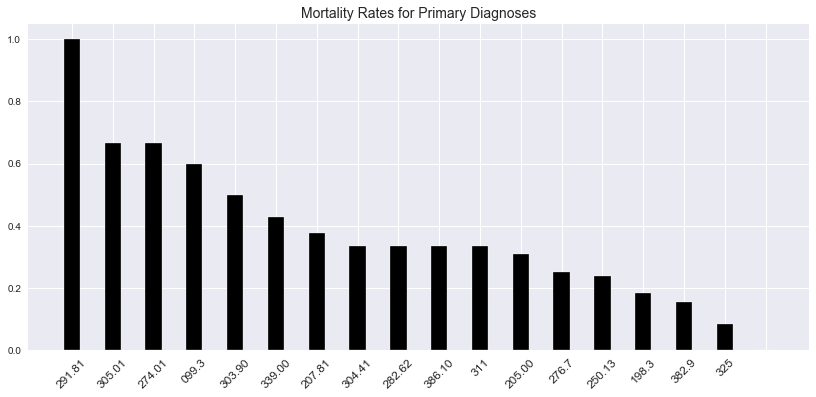

In [6]:
icd_mortality = ed_notes[['empi', 'principal_dia_code', 'principal_dia_name']].merge(dem[['empi', 'vital_status']], on='empi')
icd_mortality['vital_status'] = icd_mortality.vital_status.apply(lambda x: 1 if x == 'deceased' else np.nan_to_num(x, 0))
icd_codes = icd_mortality.groupby(['principal_dia_code']).count().reset_index().principal_dia_code.values
code_counts = icd_mortality.groupby(['principal_dia_code'])['empi'].count().values
code_mortalities = icd_mortality.groupby(['principal_dia_code'])['vital_status'].sum().values
mortality_scores = code_mortalities[code_counts > 2] / code_counts[code_counts > 2]
x_pos = np.arange(0, len(mortality_scores)/4)
icd_labels = icd_codes[np.argsort(mortality_scores)[::-1]][::4]
plt.figure(figsize=(14,6))
plt.bar(x_pos, np.sort(mortality_scores)[::-1][::4], width=0.4, color='black', edgecolor='white')
plt.xticks(x_pos, rotation=45)
ax = plt.gca()
ax.set_xticklabels(icd_labels[:-1], size=12)
plt.title('Mortality Rates for Primary Diagnoses', size=14)
plt.show();

### Define ICD Relations by Co-occurences in Dataset

Algebraic Connectivity:  0.4174408777079822
Average Clustering:  0.18187059519248722


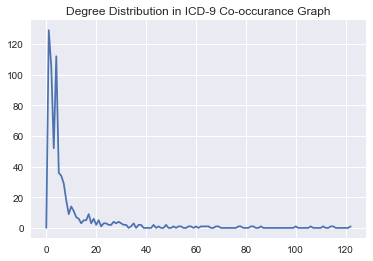

In [7]:
# define edge pairs from secondary codes to primary icd code
edges = []
for i in range(len(ed_notes)):
    if ed_notes.iloc[i].isna().sum() > 0:
        continue
    primary_code = ed_notes.principal_dia_code[i]
    if ',' in ed_notes.additional_dia_code[i]:
        secondary_codes = ed_notes.additional_dia_code[i].split(",")
        for code in secondary_codes:
            edges.append([code, primary_code])
    else:
        edges.append([ed_notes.additional_dia_code[i], primary_code])
G = nx.Graph(edges)
print('Algebraic Connectivity: ', nx.algebraic_connectivity(G))
print('Average Clustering: ', nx.average_clustering(G))
plt.plot(nx.degree_histogram(G))
plt.title('Degree Distribution in ICD-9 Co-occurance Graph');

In [8]:
# get unique icd codes
node_list = []
add_codes = np.array(ed_notes['additional_dia_code'].dropna().apply(lambda x: x.split(',') if ',' in x else x))
for l in add_codes:
    node_list += l
nodes = list(set(node_list).union(list(np.ravel(np.array(ed_notes['principal_dia_code'].values)))))
nodes = [icd9.decimal_to_short(node) for node in nodes]
edges = [[icd9.decimal_to_short(e[0]), icd9.decimal_to_short(e[1])] for e in edges]
observed_chapters = np.sort([node for node in nodes if len(node) == 3])

# optionally add edges from each chapter to highest level, center node            
for chapter in observed_chapters:
    edges.append([chapter, 'ICD-9_Diagnoses'])
nodes.append('ICD-9_Diagnoses')

In [9]:
# define a co-occurence matrix where M[i,j] gives total co-occurences between nodes i,j 
M = np.zeros((len(nodes), len(nodes)))
node_to_index = dict(zip(nodes, np.arange(len(nodes))))
for e in edges:
    M[node_to_index[e[0]], node_to_index[e[1]]] += 1

In [10]:
# define edge relations as a dataframe            
icd_df = pd.DataFrame(edges, columns=['u', 'v']).drop_duplicates()
icd_df.head()
icd_df.info()
icd_df.to_csv('data/icd_data/icd_observed_relations.csv', index=None)

,u,v
0,71946,7242
1,7862,7242
3,V6285,7242
4,99673,78659
5,71946,78659


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3084 entries, 0 to 3427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   u       3084 non-null   object
 1   v       3084 non-null   object
dtypes: object(2)
memory usage: 72.3+ KB


In [11]:
# define mappings between chapter name & range to integer class labels
observed_chapter_name_label = {}
for i, k in enumerate(observed_chapters):
    observed_chapter_name_label[k] = i

# assign each node to its chapter class label
node_labels = {}
for i in range(icd_df.shape[0]):
    u = icd_df.iloc[i, 0]
    v = icd_df.iloc[i, 1]
    if v in observed_chapters:
        node_labels[u] = observed_chapter_name_label[v]

### Train poincare model on observed ICD relations

In [12]:
# import modules within repository
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils')
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\poincaré_embeddings')
from embed import *

In [12]:
# train poincare embeddings and save output embedding coordinates
fin = 'data/icd_data/icd_observed_relations.csv' # input path with stored relations
fout = 'data/icd_data/icd_observed_embeddings_tmp.csv' # output path to write embedding coordinates

# call function to train gensim's poincare embedding model
train_embeddings(input_path=fin, delimiter=',', output_path=fout, epochs=20, burn_in_alpha=0.01, 
                 batch_size=20, burn_in=10, alpha=0.1, negative=20)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 3085 relations from train data, 668 nodes
INFO:gensim.models.poincare:training model of size 2 with -1 workers on 3085 relations for 20 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=20
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:burn-in finished
INFO:gensim.models.poincare:starting training (20 epochs)----------------------------------------
INFO:gensim.models.poincare:training finished
INFO:gensim.models.utils_any2vec:storing 668x2 projection weights into data/icd_data/icd_observed_embeddings_tmp.csv


In [13]:
# load embedding coordinates and prepare data for plotting in the poincare disk
emb = load_embeddings('data/icd_data/icd_observed_embeddings_tmp.csv', delim=' ')
emb.head()
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
edge_list = [list(arr) for arr in np.array(icd_df)]

#labels = emb.node.apply(lambda x: node_labels[x] if x in node_labels.keys() else 1)
labels = np.repeat(0, len(emb)-1)
#chapter_label_range = {v:k for k,v in chapter_range_label.items()}

,node,x,y
0,78650,0.079142,-0.225198
1,7295,-0.145697,0.098502
2,7840,0.009587,0.246111
3,78909,0.126917,-0.199367
4,53081,0.057175,-0.026216


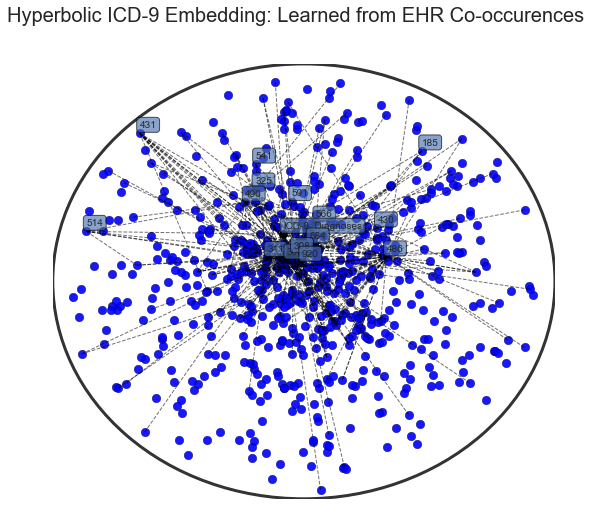

In [14]:
# import cross library module
sys.path.append('C:\\Users\\dreww\\Desktop\\vu-informatics\\utils')
from poincare_viz_icd import *

# add labels for chapters and select only high level edges
chapter_emb = emb[emb.node.apply(lambda x: x in observed_chapters)]
chapter_emb_dict = dict(zip(chapter_emb.node.values, chapter_emb.iloc[:, 1:3].values))
chapter_edges = [e for e in edge_list if e[0] in observed_chapters or e[1] in observed_chapters]

plot_poincare_icd(emb, labels, edge_list=chapter_edges, add_labels=True,
                  label_dict=chapter_emb_dict, edge_frac=1, plot_frac=1, label_frac=0,
                  save=True, title='Learned from EHR Co-occurences');

correlation:  0.16226215237212116


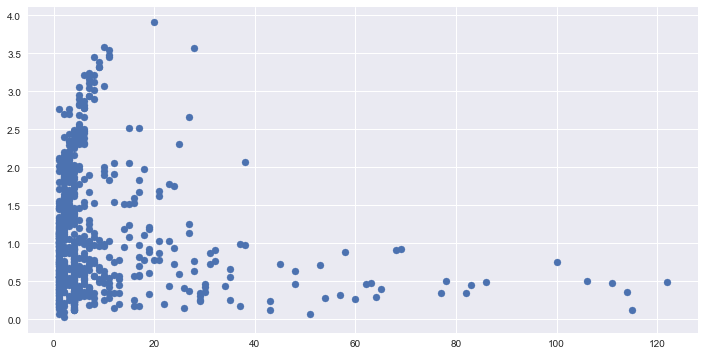

In [15]:
# plot distance from center vs. node degree
radial_dist = []
degree_counts = []
for node in G.nodes():
    radial_dist.append(poincare_dist([0, 0], emb[emb['node'] == icd9.decimal_to_short(node)].iloc[:,1:3]))
    degree_counts.append(G.degree(node))
plt.figure(figsize=(12,6))
print('correlation: ', np.abs(np.corrcoef(degree_counts, radial_dist)[0,1]))
plt.scatter(degree_counts, radial_dist);

### Load pre-trained ICD-9 Embeddings 

In [29]:
chapters = icd9.icd9Chapters
drop_supplementary = True
s1 = 'Supplementary Classification Of External Causes Of Injury And Poisoning'
s2 = 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
if drop_supplementary:
    for s in [s1, s2]:
        if s in chapters.keys():
            drop = chapters.pop(s)
    
# define mappings between chapter name & range to integer class labels
chapter_name_range = {}
for k,v in chapters.items():
    chapter_name_range[k] = v[0] + '_' + v[1]
chapter_range_name = {v:k for k,v in chapter_name_range.items()}

chapter_name_label = {}
for i, k in enumerate(chapters.keys()):
    chapter_name_label[k] = i
chapter_range_label = {k:i for i, k in enumerate(chapter_range_name)}
    
# load embedding coordinates and prepare data for plotting in the poincare disk
emb = pd.read_csv('data/icd_data/icd_final_embeddings.csv')
emb.head()

,node,x,y,node_label
0,800_999,-0.304720,-0.118744,16.0
1,001_139,0.453165,0.190884,0.0
2,140_239,0.665936,-0.607616,1.0
3,320_389,-0.790279,-0.566815,5.0
4,390_459,0.048185,-0.939577,6.0


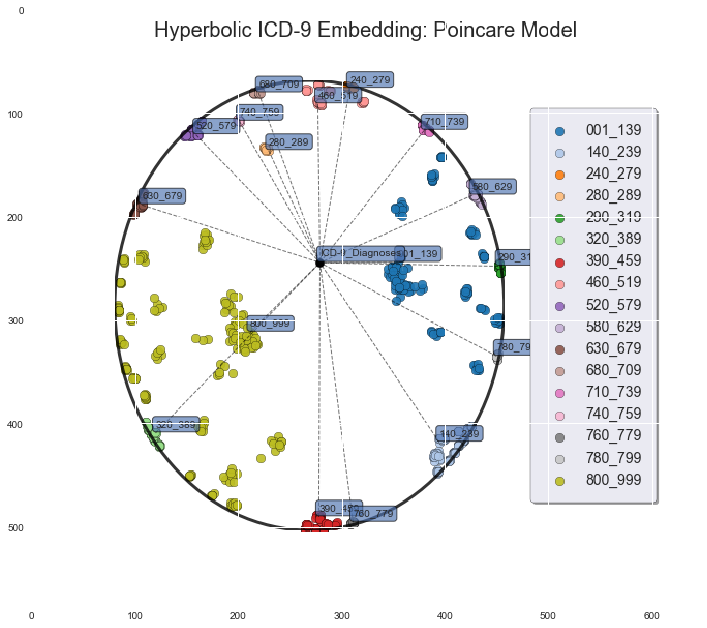

In [41]:
import matplotlib.image as mpimg
# visualize poincare icd-9 embedding
plt.figure(figsize=(12,12))
img=mpimg.imread('images/Poincare_Model_ICD9.png')
plt.imshow(img);

### Use ICD-9 Embeddings in Mortality Prediction Task

In [201]:
patient_diags = {}
for empi in dem.empi.values:
    patient_diags[empi] = diag[diag.empi == empi].dia_code.values
patient_diags

{742415486: array(['308.3', '440.0', '300.01', '272.4', '263', '2761', '300.00',
        '719.40', '402.10', '174.9', '272.4', '300.10', '789.06', '425.9',
        '250.50', '202.80', '141', '702.19', '300.10'], dtype=object),
 746287608: array(['300.01', '272.4', '2768', '401.1', '533.90', '426.13', '202.80',
        '173.3', '159', '070.54', '309.1', '308.9', '174.9', '300.09',
        '789.00'], dtype=object),
 415900342: array(['272.4', '2764', '4404', '202.80', '198.3', '308.3', '070.51',
        '433.11', '308', '2869', '465.9', '300.01', '263', '654.43',
        '272.4', '560.32', '342'], dtype=object),
 967071533: array(['308.9', '188.5', '300', '200.78', '425.9', '308.9', '309.1',
        '272.4', '789.00', '308.3'], dtype=object),
 679830259: array(['789.00', '272.4', '787.01', '174.9', '426.11', '296.34', '300.09',
        '174.9', '174.9', '274.01', '196.3', '702.19', '263'], dtype=object),
 148750564: array(['308.9', '401.1', '272.4', '416', '396.3', '173.3', '724.2', '159

In [198]:
dem['vital_status'] = dem['vital_status'].fillna(0).replace('deceased', 1)
ehr_data = dem[['empi', 'gender', 'age', 'vital_status']].merge(diag.groupby(['empi'])['dia_code'].count().reset_index(), on=['empi'])
ehr_data.rename(columns={"vital_status":"deceased", "dia_code": "num_diags"}, inplace=True)
ehr_data.head()

,empi,gender,age,deceased,num_diags
0,742415486,female,77,0,19
1,746287608,female,31,0,15
2,415900342,female,96,0,17
3,967071533,female,67,0,10
4,679830259,female,47,0,13


In [199]:
num_visits = ed_notes.groupby(['empi'])['visit_date'].count().reset_index()
num_visits.columns = ['empi', 'er_visits']
avg_los = ed_notes.groupby(['empi'])['length_of_stay'].mean().reset_index()
avg_los.columns = ['empi', 'avg_length_of_stay']
num_visits.merge(avg_los, on=['empi']).head()

,empi,er_visits,avg_length_of_stay
0,101962493,2,234.500000
1,115649349,1,333.000000
2,116008610,3,280.333333
3,117990558,1,142.000000
4,117997941,4,262.500000


### Explore other real world data sources

In [24]:
nysdoh = pd.read_csv('data/NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2015.csv')
nysdoh.head()
nysdoh.shape
nysdoh.columns

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,"5,333.90","4,818.42",0.903358
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Medical,Medicare,NaN,NaN,0,N,Y,"4,865.99","4,588.78",0.943032
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,"5,901.54","5,559.56",0.942052
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,...,Medical,Medicare,NaN,NaN,0,N,Y,"3,619.08","3,567.25",0.985679
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,...,Medical,Medicare,Blue Cross/Blue Shield,Private Health Insurance,0,N,Y,"3,185.87","3,167.89",0.994357


(2346931, 35)

Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCS Diagnosis Code',
       'CCS Diagnosis Description', 'CCS Procedure Code',
       'CCS Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3', 'Birth Weight',
       'Abortion Edit Indicator', 'Emergency Department Indicator',
       'Total Charges', 'Total Costs',
       'Ratio of Total Costs to Total Charges'],
      dtype='object')

In [25]:
# only the ADMISSIONS table from MIMIC-III
mimic = pd.read_csv('data/MIMIC/mimic3d.csv')
mimic.head()
mimic.shape
mimic.columns
mimic.hadm_id.nunique()
mimic.ExpiredHospital.value_counts()

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,...,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,1
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,...,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,1


(58976, 28)

Index(['hadm_id', 'gender', 'age', 'LOSdays', 'admit_type', 'admit_location',
       'AdmitDiagnosis', 'insurance', 'religion', 'marital_status',
       'ethnicity', 'NumCallouts', 'NumDiagnosis', 'NumProcs',
       'AdmitProcedure', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs',
       'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum'],
      dtype='object')

58976

0    53122
1     5854
Name: ExpiredHospital, dtype: int64